# Opinion dynamics over discourse sheaves

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import null_space, expm
from scipy.integrate import solve_ivp

from builder import SheafBuilder
from models import SheafDynamic
from visualization import opinion_trajectory_plot

from itertools import combinations

## Constant sheaves with stalk equal to $\mathbb{R}^n$ on each vertex and node

### Opinion diffusion via Laplacian heat equation 

In [2]:
sheaf = SheafBuilder(7, 5, constant = False)

x0 = sheaf.initial_state()*5
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.01, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0)

np.real(np.linalg.eigvals(sheaf.L_f))

array([ 5.55852757e+01,  5.09040634e+01,  4.09560063e+01,  3.80538660e+01,
        3.51061164e+01,  2.68887348e+01,  2.34171394e+01,  2.23801994e+01,
        2.07176003e+01,  2.52853762e+01,  1.64646747e+01,  1.56024692e+01,
        1.28393820e+01,  1.11181723e+01,  1.01363889e+01,  9.08047209e+00,
        8.14744137e+00,  8.82853949e-01,  1.08690890e+00,  1.92096448e+00,
        2.60572320e+00,  7.02344760e+00,  6.15808807e+00,  3.50535123e+00,
        4.25955386e+00,  4.62230896e+00,  1.88780722e+01,  1.38219073e+01,
        3.40185712e+00,  5.29123423e+00,  1.41625817e-15,  1.41625817e-15,
       -1.01519254e-15,  1.41669831e-15,  3.57846960e-16])

In [3]:
trajectories_1 = dynamic.privateOpinionDynamicSolver()

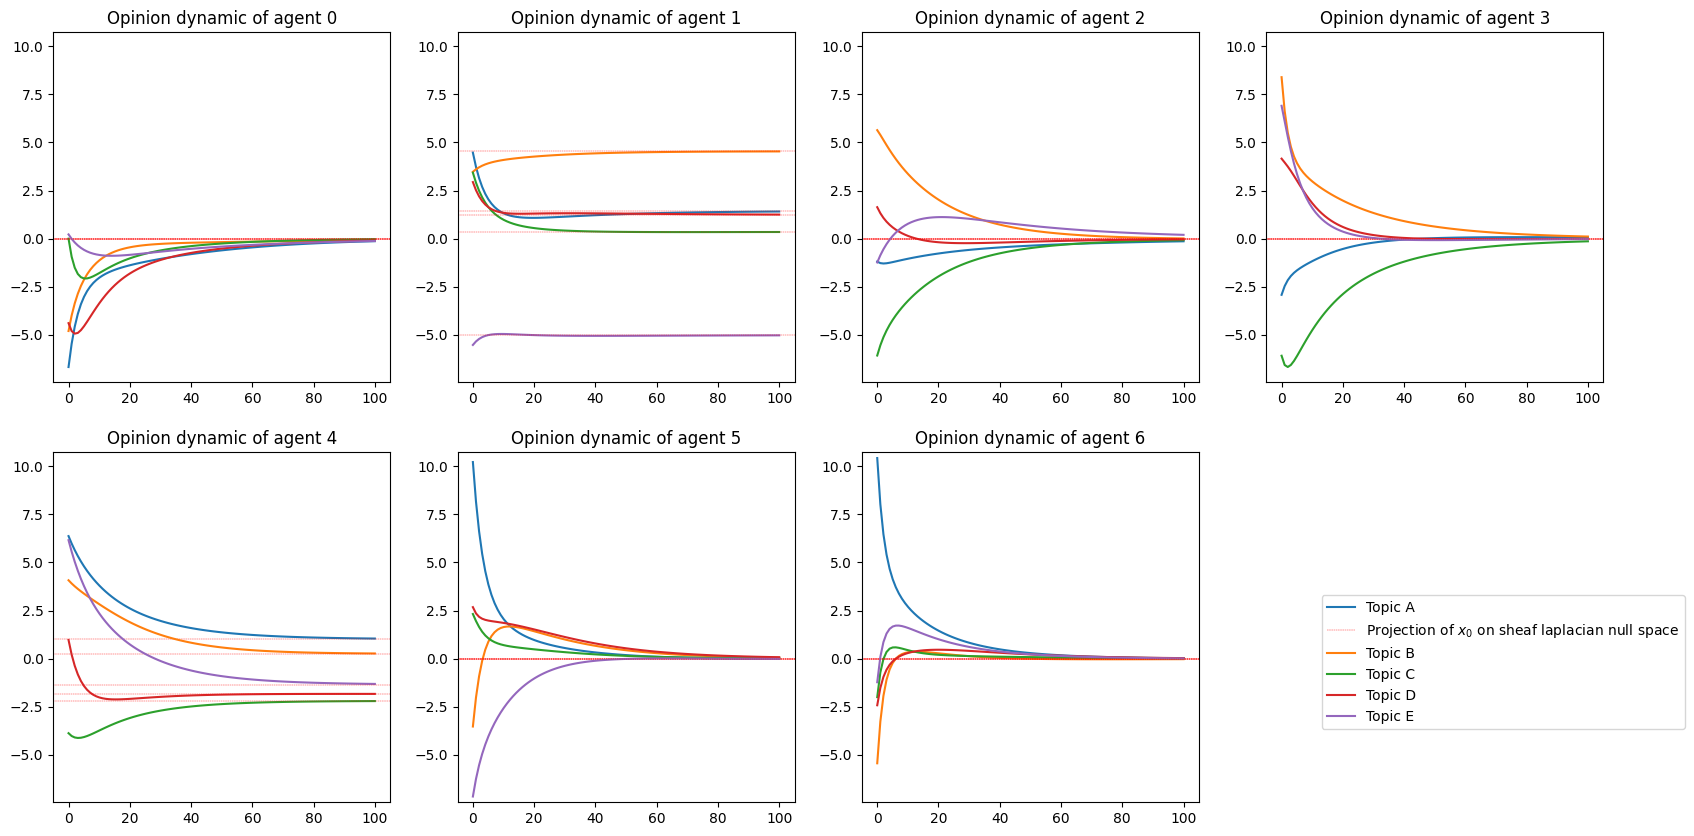

In [4]:
opinion_trajectory_plot(trajectories_1, dynamic.time_points, sheaf.d, range(sheaf.V), x_null)

### Modeling stubborn agents requires just restriction over the dynamics

In [5]:
U = np.random.choice(7, 3, replace = False)
sheaf = SheafBuilder(7, 5, constant = True, stubborn = U)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U)

In [6]:
trajectories_2 = dynamic.privateOpinionDynamicSolver()

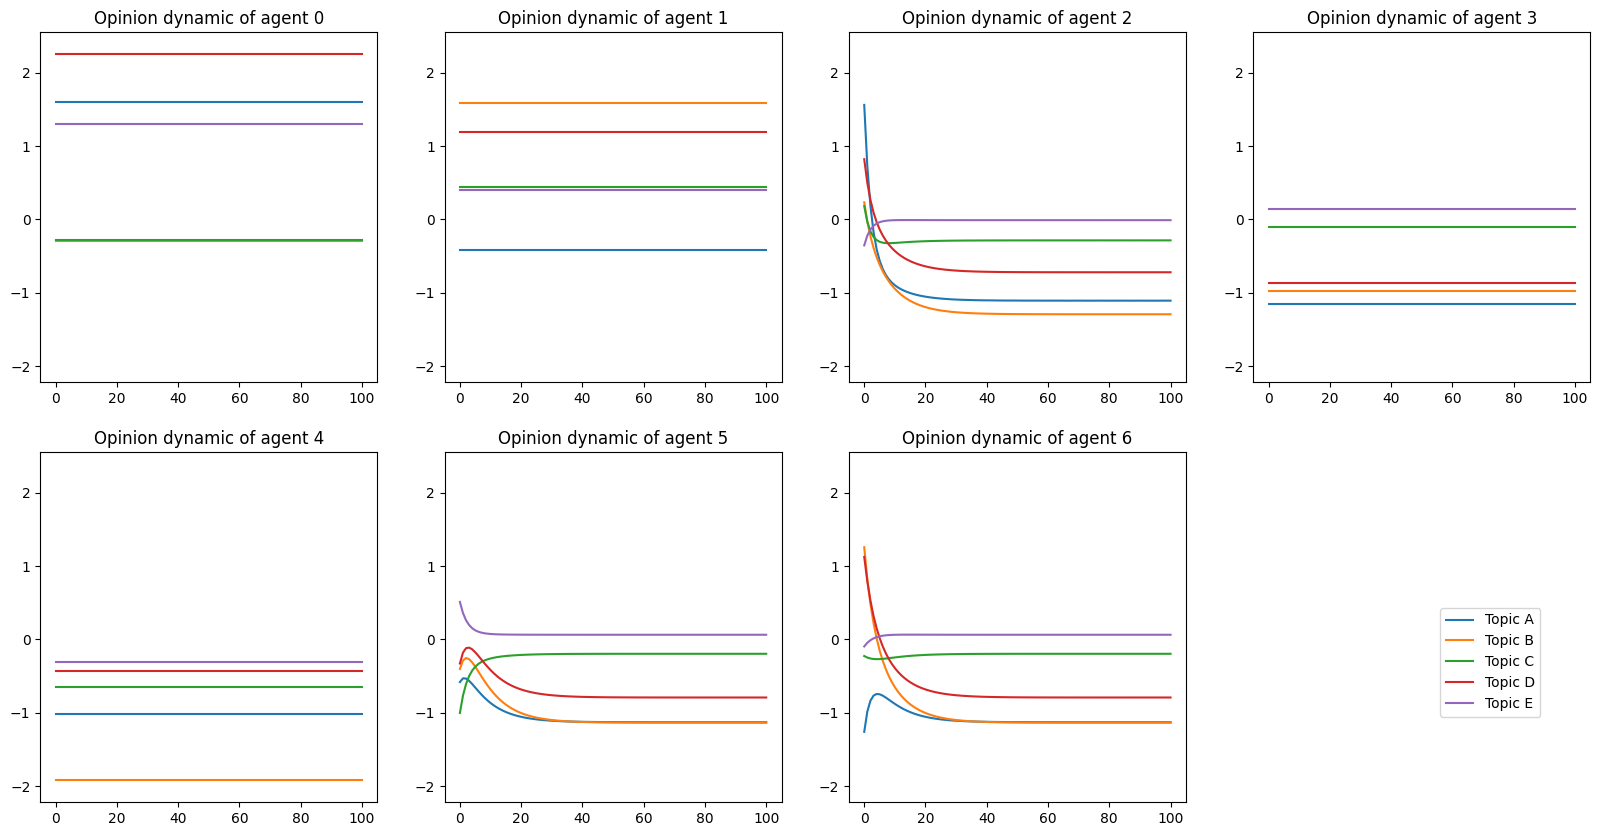

In [7]:
opinion_trajectory_plot(trajectories_2, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Beyond stubborness: forcing opinions 

In [8]:
U = np.random.choice(7, 1, replace = False)
Y = [agent for agent in range(7) if agent not in U]

sheaf = SheafBuilder(7, 4, constant = True, stubborn = U, control = Y)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U, 
    Y = Y)

In [9]:
_, trajectories_3 = dynamic.forcingOpinionDynamicSolver()

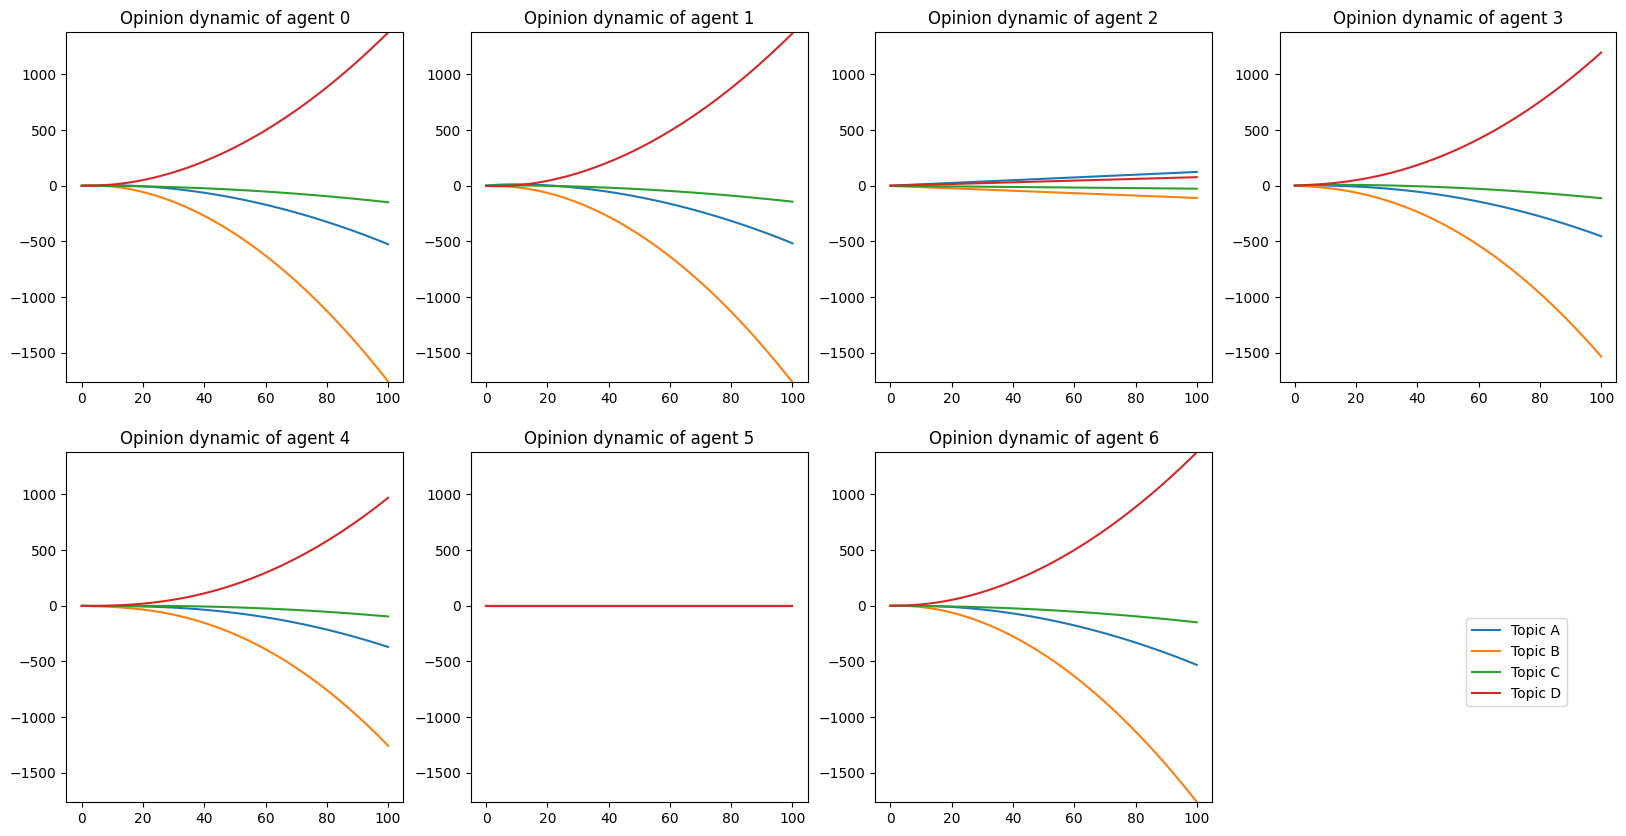

In [10]:
opinion_trajectory_plot(trajectories_3, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Weighted reluctance: augmenting the network with stubborn parents 

In [11]:
sheaf = SheafBuilder(7, 5)
sheaf.augmentedConstantSheaf(gamma = 1)

x0 = sheaf.augmented_initial_state()
x_null = sheaf.null_space_projector(x0)

In [12]:
dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = sheaf.nodes[int(len(sheaf.nodes)/2):])

In [13]:
trajectories_4 = dynamic.privateOpinionDynamicSolver()

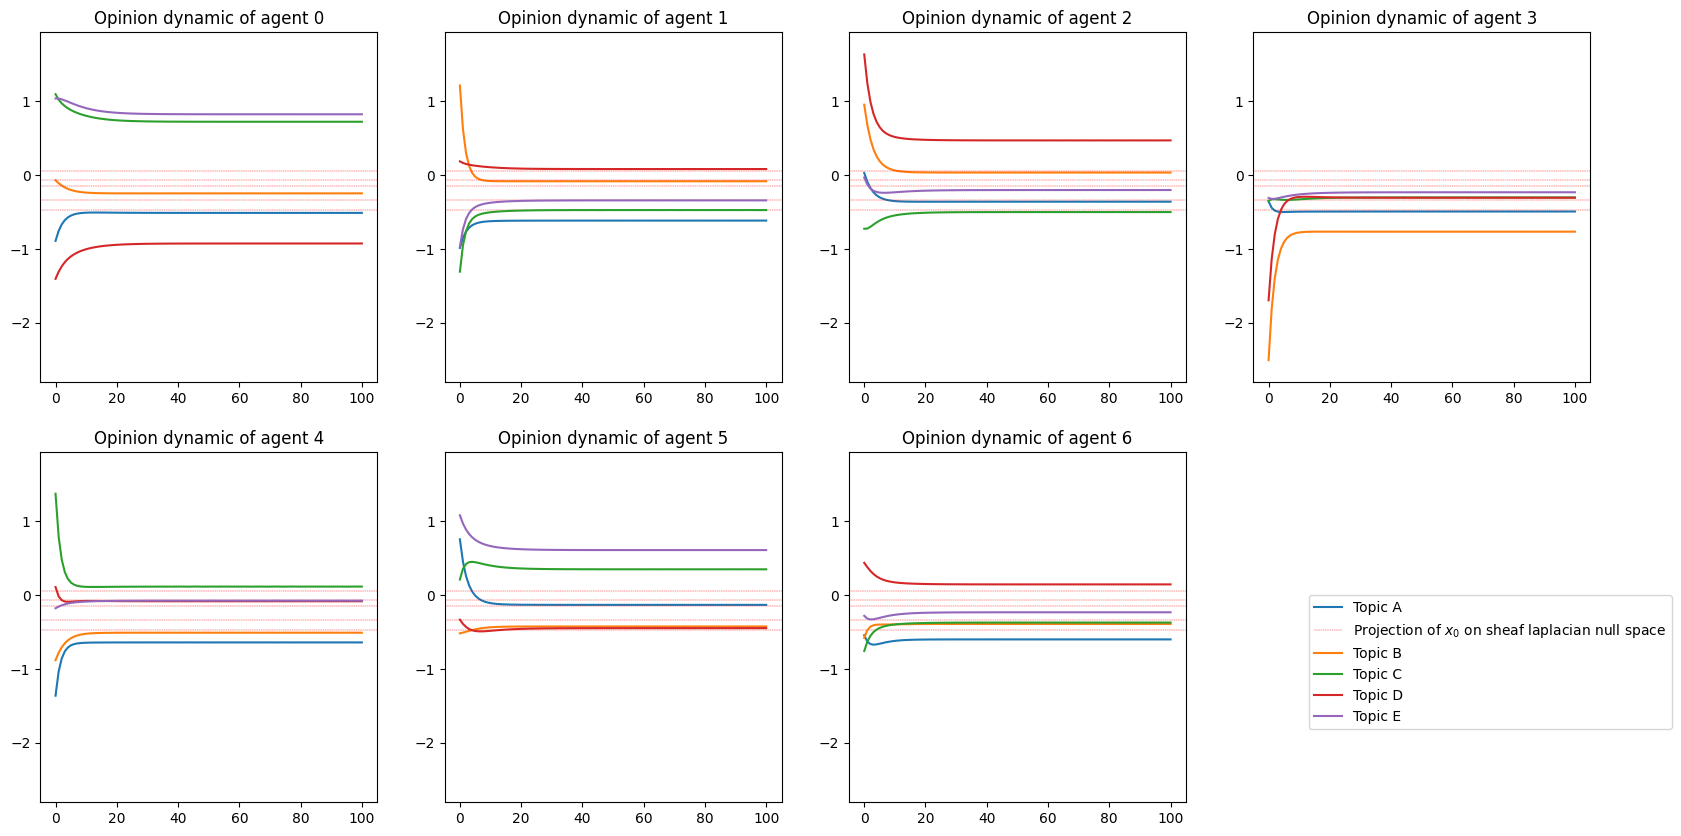

In [14]:
opinion_trajectory_plot(trajectories_4, dynamic.time_points, sheaf.d, range(sheaf.V), x_null)

### Expression diffusion for "learning to lie" dynamics

In [15]:
sheaf = SheafBuilder(7, 3)
x0 = sheaf.initial_state()

In [16]:
dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    int(len(sheaf.edges)), 
    sheaf.V, 
    sheaf.d, 
    x0)

In [17]:
trajectories_5, disagreement = dynamic.expressionDynamicSolver()

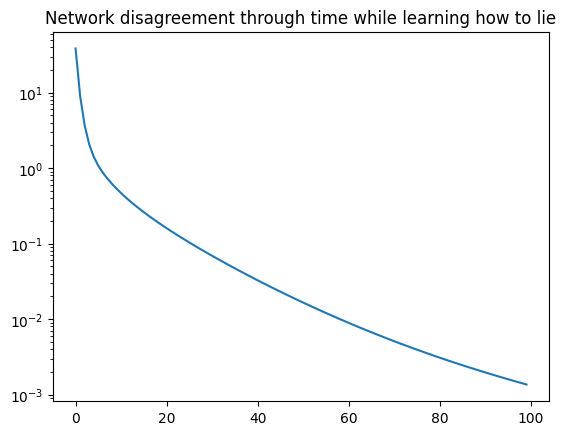

In [18]:
plt.plot(disagreement)
plt.title('Network disagreement through time while learning how to lie')
plt.yscale('log')

_______________

# Simplicial Complex Dynamics

In [19]:
def randomGraph(
        V,
        cutoff
    ):

    edges = []

    points = np.random.rand(V, 2)

    A = np.zeros((V,V))

    for i in range(V):
        for j in range(i + 1, V):
            
            A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff
            A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff

            if A[i,j] == 1:
                edges.append((i,j))
    
    return A, edges

def triangleFinder(V, edges):
    all_cliques = list(combinations(range(V), 3)) 
    true_cliques = []
    for clique in all_cliques:
        u, v, w = clique[0], clique[1], clique[2]
        A = ((u,v) in edges or (v,u) in edges)
        B = ((v,w) in edges or (w,v) in edges)
        C = ((w,u) in edges or (u,w) in edges)

        if A and B and C:
            true_cliques.append((u,v,w))

    return true_cliques

def random2SC(V, cutoff, ntriangles):
    A, edges = randomGraph(V, cutoff)
    all_triangles = triangleFinder(V, edges)
    T = [all_triangles[i] for i in np.random.choice(len(all_triangles), ntriangles, replace=False).tolist()]

    return {
        'Vertices':list(range(V)),
        'Edges':edges,
        'Triangles':T
    }

In [20]:
def SCLaplacians(SC):
    V = SC['Vertices']
    E = SC['Edges']
    T = SC['Triangles']

    B0 = np.zeros((len(V), len(E)))
    B1 = np.zeros((len(E), len(T)))

    edges_idxs = {}

    for i, edge in enumerate(E):

        B0[edge[0], i] = -1
        B0[edge[1], i] = 1
        edges_idxs[edge] = i

    
    for j, triangle in enumerate(T):
        e1 = (triangle[0], triangle[1])
        e2 = (triangle[1], triangle[2])
        e3 = (triangle[0], triangle[2])

        B1[edges_idxs[e1], j] = 1 if B0[e1[0], edges_idxs[e1]] == -1 else -1
        B1[edges_idxs[e2], j] = 1 if B0[e2[0], edges_idxs[e2]] == -1 else -1
        B1[edges_idxs[e3], j] = 1 if B0[e3[0], edges_idxs[e3]] == 1 else -1

    L0 = B0 @ B0.T
    L1 = B0.T @ B0 + B1 @ B1.T

    return B0, L0, B1, L1

In [21]:
SC = random2SC(15, 0.6, 2)

In [22]:
B0, L0, B1, L1 = SCLaplacians(SC)

In [23]:
class SimplicialSheafBuilder:
    
    def __init__(
            self, 
            V, 
            d,
            ntriangles = 'Full',
            cutoff = 0.5
            ):

        self.V = V
        self.nodes = list(range(self.V))
        self.d = d
        self.ntriangles = ntriangles
        self.cutoff = cutoff

        # Graph builder
        self.randomGraph()

        # Simplicial builder
        self.random2SC()

        # Sheaf builder
        self.SCSbuilder()

    def randomGraph(
            self
        ):

        self.edges = []

        points = np.random.rand(self.V, 2)

        self.A = np.zeros((self.V,self.V))

        for i in range(self.V):
            for j in range(i + 1, self.V):
                
                self.A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= self.cutoff
                self.A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= self.cutoff

                if self.A[i,j] == 1:
                    self.edges.append((i,j))

    def triangleFinder(self):
        all_cliques = list(combinations(range(self.V), 3)) 
        true_cliques = []
        for clique in all_cliques:
            u, v, w = clique[0], clique[1], clique[2]
            A = ((u,v) in self.edges or (v,u) in self.edges)
            B = ((v,w) in self.edges or (w,v) in self.edges)
            C = ((w,u) in self.edges or (u,w) in self.edges)

            if A and B and C:
                true_cliques.append((u,v,w))

        return true_cliques
    
    def random2SC(self):
        all_triangles = self.triangleFinder()
        if self.ntriangles == 'Full':
            self.triangles = all_triangles
        else:
            T = [all_triangles[i] for i in np.random.choice(len(all_triangles), self.ntriangles, replace=False).tolist()]
            self.triangles = T
    
    def SCSbuilder(
            self
        ):

        # Coboundary maps

        self.B0 = np.zeros((self.d*self.V, self.d*len(self.edges)))               
        self.B0_graph = np.zeros((self.V, len(self.edges))) 

        self.B1 = np.zeros((self.d*len(self.edges), self.d*len(self.triangles)))
        
        edges_idxs = {}

        for i, edge in enumerate(self.edges):

            u = edge[0] 
            v = edge[1] 

            self.B0[u*self.d:(u+1)*self.d, i*self.d:(i+1)*self.d] = - np.eye(self.d)      
            self.B0[v*self.d:(v+1)*self.d, i*self.d:(i+1)*self.d] = np.eye(self.d)

            self.B0_graph[u, i] = -1
            self.B0_graph[v, i] = 1

            edges_idxs[edge] = i

        for j, triangle in enumerate(self.triangles):
                e1 = (triangle[0], triangle[1])
                e2 = (triangle[1], triangle[2])
                e3 = (triangle[0], triangle[2])

                self.B1[self.d*edges_idxs[e1]:self.d*(edges_idxs[e1]+1), j*self.d:(j+1)*self.d] = np.eye(self.d) 
                self.B1[self.d*edges_idxs[e2]:self.d*(edges_idxs[e2]+1), j*self.d:(j+1)*self.d] = - np.eye(self.d)
                self.B1[self.d*edges_idxs[e3]:self.d*(edges_idxs[e3]+1), j*self.d:(j+1)*self.d] = - np.eye(self.d)

        self.L0 = self.B0 @ self.B0.T
        self.L1 = self.B0.T @ self.B0 + self.B1 @ self.B1.T

    def initial_vertex_flow(self): 

        return np.random.randn(self.V*self.d)
    
    def initial_edge_flow(self):
        
        return np.random.randn(len(self.edges)*self.d)

In [24]:
class SimplicialSheafDynamic:
    def __init__(
            self, 
            SC, 
            alpha, 
            beta,
            T = 100,
            timespan = 100,
        ):

        # Simplicial sheaf
        self.SC = SC

        # Parameter in the dynamics
        self.alpha = alpha
        self.beta = beta
        
        # Considered timewindow
        self.T = T
        self.timespan = timespan 
        self.time_points = np.linspace(0,self. T, self.timespan)

    ##############################
    #### METHODS FOR DYNAMICS ####
    ##############################

    def edgeFlowSolved(self, t, xi_0):
        
        return expm(- self.beta * self.SC.L1 * t) @ xi_0
    
    def vertexFlowDynamic(self, t, x, xi_0):

        dxdt = - self.alpha * self.SC.B0 @ self.edgeFlowSolved(t, xi_0)
        return dxdt
    
    def solver(
            self
        ):

        x0 = self.SC.initial_vertex_flow()
        xi0 = self.SC.initial_edge_flow()

        solution = solve_ivp(
            self.vertexFlowDynamic, 
            [0, self.T], 
            x0, 
            t_eval=self.time_points, 
            args=(xi0,),
            method='RK45'
            )
        
        trajectory_x = solution.y.T
        trajectory_xi = self.edgeTrajectory(xi0)

        return trajectory_x, trajectory_xi
    
    def edgeTrajectory(self, xi_0):

        return np.array([self.edgeFlowSolved(t, xi_0) for t in self.time_points])

In [25]:
SC = SimplicialSheafBuilder(7, 5, 2)

In [26]:
dynamic = SimplicialSheafDynamic(SC, 0.1, 0.1)

In [27]:
x_traj, xi_traj = dynamic.solver()

In [28]:
null = null_space(SC.L0)
proj = null @ null.T

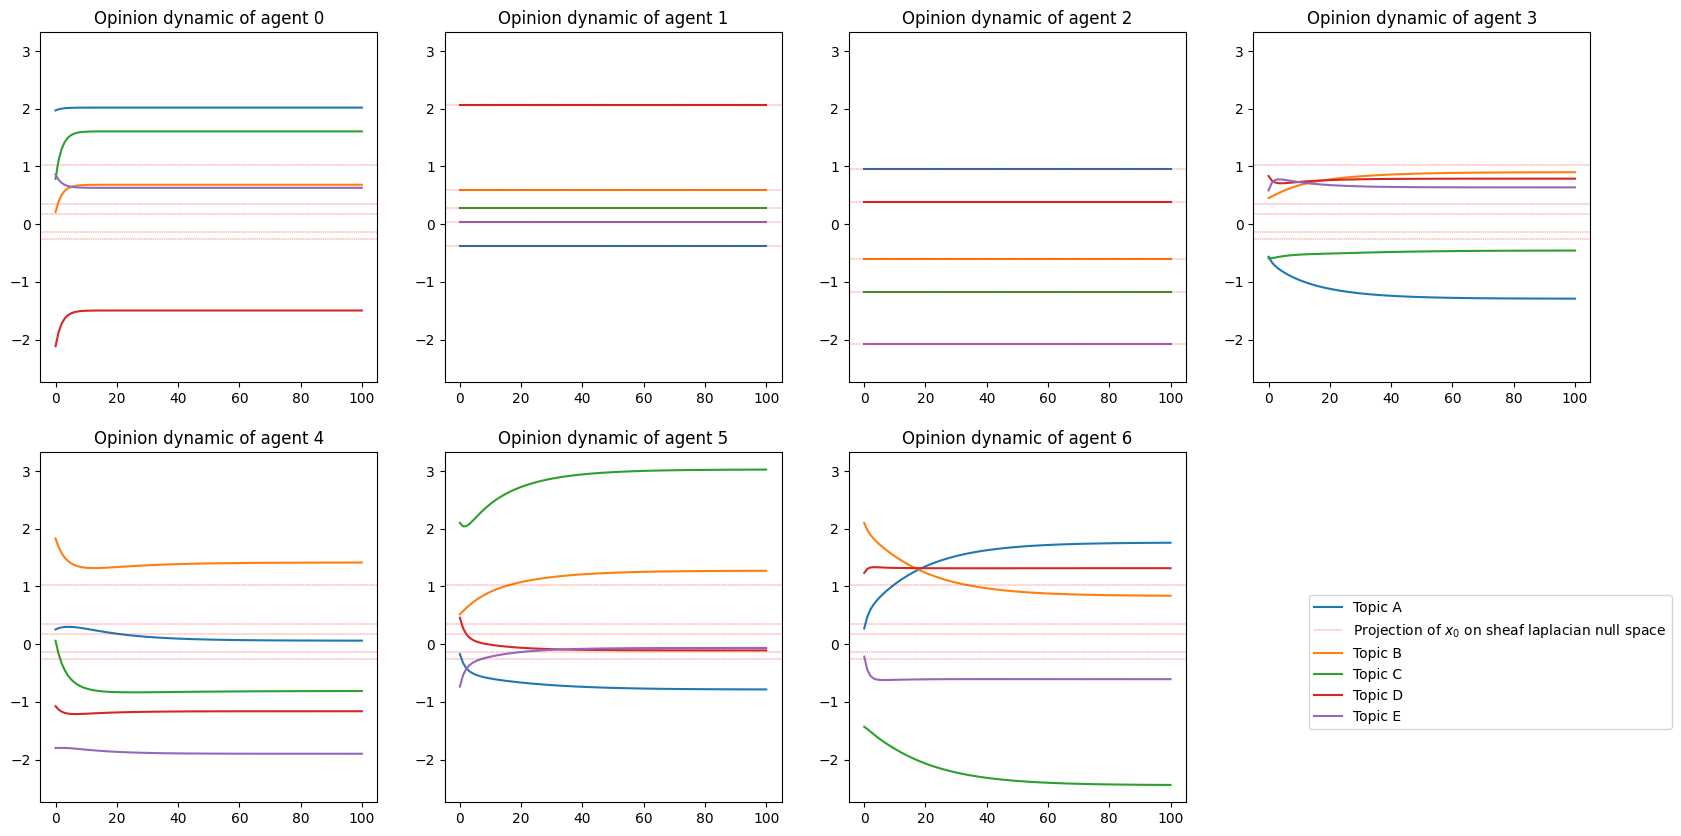

In [29]:
opinion_trajectory_plot(x_traj, dynamic.time_points, SC.d, range(SC.V), proj @ x_traj[0,:])

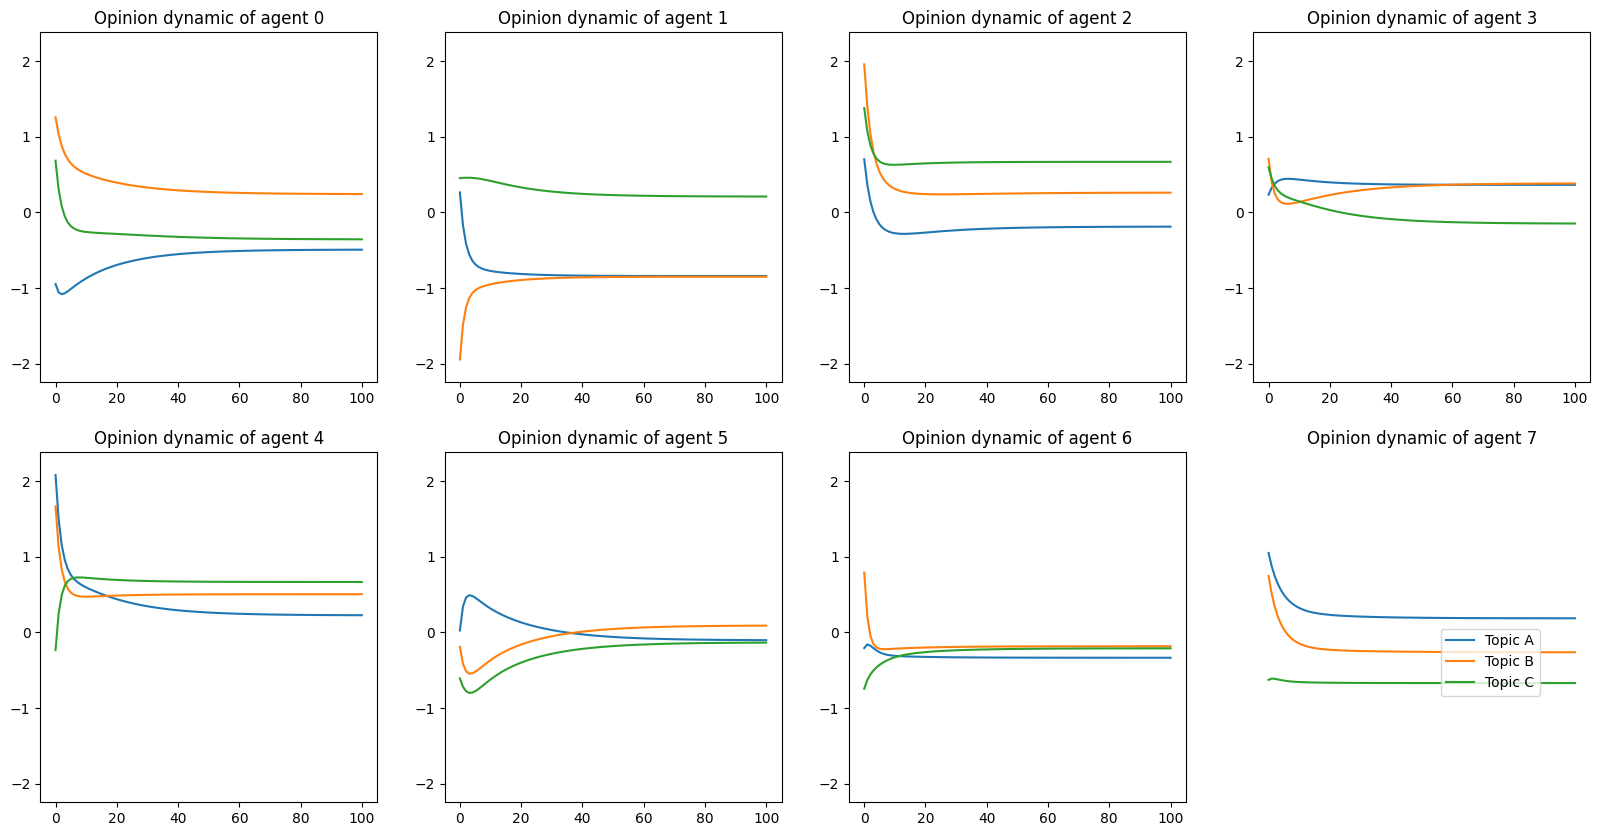

In [30]:
opinion_trajectory_plot(xi_traj , dynamic.time_points, 3, range(len(SC.edges)))

In [37]:
null_2 = null_space(SC.L1)
proj_2 = null_2 @ null_2.T

In [38]:
x_traj[99,:].T @ SC.L0 @ x_traj[99,:]

156.03708670651392

In [39]:
xi_traj[99,:].T @ SC.L1 @ xi_traj[99,:]

5.7740935942499676e-05

In [40]:
SC.triangles

[(0, 5, 6), (0, 3, 6)]

In [35]:
xi_hat = xi_traj[99,:]

In [36]:
SC.B1[:,5:10].T @ xi_hat

array([-1.99680753e-03,  1.87865294e-03,  1.66357004e-03,  3.77974650e-05,
       -6.94671873e-05])

In [42]:
x_hat = x_traj[99,:]

In [43]:
SC.edges

[(0, 3), (0, 4), (0, 5), (0, 6), (3, 4), (3, 5), (3, 6), (5, 6)]